In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
from sklearn.metrics import r2_score, mean_squared_error

from nldg.utils import generate_data_example_1, gen_data_isd, gen_data_maximin
from nldg.maximin import MaximinRF
from nldg.isd import IsdRF

import matplotlib.pyplot as plt

from tqdm import tqdm

## Maximin

### Method 1

Inspired by the maximin effect estimator (see [1]), we modify the Random Forest to allow for robustness against distribution shifts.

In [42]:
#dtr, dts, _, _ = gen_data_isd(1000, 500,
#                              np.random.default_rng(42), 
#                              np.random.default_rng(42))
#dtr, dts = generate_data_example_1(42, False)
dtr, dts = gen_data_maximin(1000, 500,
                            np.random.default_rng(42), 
                            np.random.default_rng(42))
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

In [43]:
m_try = 4
rf = MaximinRF(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)

MaximinRF(max_features=4)

In [44]:
preds = rf.predict(Xts)
wpreds, weights = rf.predict_maximin(Xtr, Ytr, Etr, Xts, wtype='inv')

In [45]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(108.6325514494339, -0.07237826558790794)

In [46]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(108.7181273623798, -0.07322303769237015)

### Method 2

To aggregate the predictions from each environment, we need to compute the weights using magging (see [2]). Note that in [3] they use the same data for fitting the models and finding the weights through the optimization procedure. In the following, we instead further split the train data into train and validation data. The latter will be used to compute the weights.

In [ ]:
Xtr_v2, Xval, Ytr_v2, Yval, Etr_v2, Eval = train_test_split(
    Xtr, Ytr, Etr, test_size=0.25, stratify=Etr, random_state=42
)

In [ ]:
m_try = 4
preds_default_val = []
preds_default_test = []

unique_envs = np.unique(Etr_v2)
n_envs = len(unique_envs)

for env in unique_envs:
    rf_env = RandomForestRegressor(n_estimators=50, oob_score=True, bootstrap=True, 
                                   random_state=42, max_features=m_try)
    
    env_idx_train = np.where(Etr_v2 == env)[0]
    
    rf_env.fit(Xtr_v2[env_idx_train], Ytr_v2[env_idx_train])
    
    preds_default_val.append(rf_env.predict(Xval))
    preds_default_test.append(rf_env.predict(Xtr))
    
preds_default_val = np.column_stack(preds_default_val)
preds_default_test = np.column_stack(preds_default_test)

In [ ]:
weights_default = np.array([1/n_envs] * n_envs)

def objective(w, F):
    return np.dot(w.T, np.dot(F.T, F).dot(w))

constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w)-1}]
bounds = [[0,1] for _ in range(preds_default_val.shape[1])]

weights_magging = minimize(objective, weights_default, args=(preds_default_val,), 
                           bounds=bounds, constraints=constraints).x

In [ ]:
weights_magging

In [ ]:
wpreds = np.dot(weights_magging, preds_default_test.T)
preds = np.dot(weights_default, preds_default_test.T)

In [ ]:
mean_squared_error(Yts, wpreds), mean_squared_error(Yts, preds)

This method is not working apparently, as the score computed with magging was expected to be lower (because using average weights does not protect against the worst case performance).

## Invariant Subspace Decomposition

We modify the algorithm proposed in [4] to allow for nonlinear relationships between the features and the response.

In [57]:
dtr, dts, _, _ = gen_data_isd(1000, 500,
                              np.random.default_rng(42), 
                              np.random.default_rng(42))
Xtr, Xts = dtr.drop(columns=['E', 'Y']), dts.drop(columns=['E', 'Y'])
Ytr, Yts = dtr['Y'], dts['Y']

In [58]:
isd_rf = IsdRF()
isd_rf.fit_isd(dtr)
preds_isd_rf = isd_rf.predict_isd(Xts)

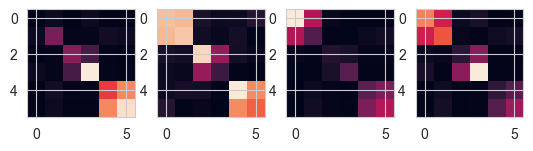

In [59]:
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(np.abs(isd_rf.Sigma_diag[i, :, :]))
plt.show()

# Checks
#isd_rf.th_opt
#isd_rf.th_const
#isd_rf._check_const(isd_rf.blocks_shape, isd_rf.th_const, isd_rf.th_opt)
#isd_rf.var
#isd_rf.var_th

In [60]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_features=1.0)
rf.fit(Xtr, Ytr)
preds_rf = rf.predict(Xts)

In [61]:
mean_squared_error(Yts, preds_isd_rf), r2_score(Yts, preds_isd_rf)

(5.049763412196055, -0.29510328595446156)

In [62]:
mean_squared_error(Yts, preds_rf), r2_score(Yts, preds_rf)

(7.570433125255678, -0.9415746870313928)

### References

[1] [**Maximin Effects in Inhomogeneous Large-Scale Data**](https://people.math.ethz.ch/~nicolai/maximin_aos.pdf)
[2] [**Magging: Maximin Aggregation for Inhomogeneous Large-Scale Data**](https://stat.ethz.ch/Manuscripts/buhlmann/ProcIEEE-magging.pdf)
[3] [**Comments on: A random forest guided tour**](https://people.math.ethz.ch/~peterbu/Files/Manuscripts/RFdiscussion-TEST2016.pdf)
[4] [**Invariant Subspace Decomposition**](https://arxiv.org/pdf/2404.09962)